# Midterm 3 - Assignment 2
## Diego Arcelli - 647979
### Training a Convolutional Neural Network on CIFAR-10 dataset and test it on adversarial examples generated with the Fast Gradient Sign Method

### Importing needed modules

In [ ]:
from torch import nn
from torch import Tensor
import torch
import random
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch import nn
from torch.utils.data import random_split
from os.path import exists
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from torch.nn.functional import softmax
!pip install torchsummary
from torchsummary import summary

### Defining the network

I realized a ResNet-like network which is composed by four main group of layers (Layer class in the code):
1. The first produces 32 features maps of 16x16 pixels
2. The second produces 64 features maps of 8x8 pixels
3. The third produces 128 features maps of 4x4 pixels
4. The fourth produces 256 features maps of 2x2 pixels

In order to donwsample the features maps at the end of each group of layers I used a max pooling layer.  

Each group is composed by 8 sub-groups of layers (Block class in the code). The structure of each sub-group is the following:
1. A convolutional layer with a 3x3 kernel and 1x1 padding
2. A batch normalization layer
3. A ReLU activation function
4. Another convolutional layer with a 3x3 kernel and 1x1 padding
5. Another batch normalization layer
6. A residual connection where the input of the sub-group is added to the output of the above layers
7. Another ReLU activation functions

About the residual connection, if the shape of the input tensor of the sub-group and the shape of the tensor produced by layers of the sub-group doesn't match, in order to apply the residual connection the input of the sub-group is passed to a downsample module composed by:
1. A convolutional layer with 3x3 kernel, 1x1 padding and 2x2 stride (which will halve the size of each feature map)
2. A batch normalization layer

Then the features maps are flatten to be used as input of the Multi Layer Peceptron for the classification, which is composed by:
* A first dense layer composed by 1024x1024 connections 
* A ReLU activation function
* A second dense layer composed by 1024x10 connections

In [ ]:
class Block(nn.Module):


    def __init__(self, in_channels, out_channels, downsample = False) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3,3), (1,1), (1,1))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, (3,3), (1,1) , (1,1))
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)
        self.downsample = downsample
        if downsample:
            self.conv_downsample = nn.Conv2d(in_channels, out_channels, (3,3), (1,1) , (1,1))
            self.bn_downsample = nn.BatchNorm2d(out_channels)

    
    def forward(self, x : Tensor) -> Tensor:

        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample: 
            residual = self.conv_downsample(residual)
            residual = self.bn_downsample(residual)

        x += residual

        x = self.relu(x)

        return x


class Layer(nn.Module):


    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.block_1 = Block(in_channels, out_channels, True)
        self.block_2 = Block(out_channels, out_channels)
        self.block_3 = Block(out_channels, out_channels)
        self.block_4 = Block(out_channels, out_channels)
        self.block_5 = Block(out_channels, out_channels)
        self.block_6 = Block(out_channels, out_channels)
        self.block_7= Block(out_channels, out_channels)
        self.block_8 = Block(out_channels, out_channels)
        self.pool = nn.MaxPool2d((2,2))        


    def forward(self, x : Tensor) -> Tensor:
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.block_6(x)
        x = self.block_7(x)
        x = self.block_8(x)
        x = self.pool(x)
        return x


class Network(nn.Module):

    def __init__(self, classes) -> nn.Module:
        super().__init__()
        self.classes = classes
        self.layer_1 = Layer(3, 32)
        self.layer_2 = Layer(32, 64)
        self.layer_3 = Layer(64, 128)
        self.layer_4 = Layer(128, 256)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, self.classes)
        self.relu = nn.ReLU(True)
        

    def forward(self, x : Tensor) -> Tensor:
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Network(10)
model.to(device)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
            Conv2d-6           [-1, 32, 32, 32]             896
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
             Block-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]           9,248
      BatchNorm2d-11           [-1, 32, 32, 32]              64
             ReLU-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,248
      BatchNorm2d-14           [-1, 32,

### Loading the CIFAR-10 training set and training the network

The network is trained on the CIFAR-10 training set (50000 images) using the stochastic gradient descent with momentum. The parameters used are the following:
* Learning rate: 0.01
* Batch size: 128
* Momentum: 0.9
* The cross entropy as loss function

We randomly extract the 5% of images of the training set (so 2500 images) in order to use them for the validation phase during the training. 

After some tests I found out that after 12 epochs the accuracy of the network on the validation set stops to grow, stabilizing around the 80%, so I picked 16 as number of epochs.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10/cifar-10-python.tar.gz to ./cifar-10/
[1 0] Train Loss: 2.7684383392333984 Train Accuracy: 0.125
[1 30] Train Loss: 2.881029728920229 Train Accuracy: 0.09198588709677419
[1 60] Train Loss: 2.5961201230033497 Train Accuracy: 0.1020747950819672
[1 90] Train Loss: 2.497236574089134 Train Accuracy: 0.10448145604395605
[1 120] Train Loss: 2.445390752524384 Train Accuracy: 0.10698605371900827
[1 150] Train Loss: 2.409455975159904 Train Accuracy: 0.11299668874172185
[1 180] Train Loss: 2.376843730389084 Train Accuracy: 0.12236705801104972
[1 210] Train Loss: 2.344246320814883 Train Accuracy: 0.13240521327014218
[1 240] Train Loss: 2.306780329383755 Train Accuracy: 0.14461229253112035
[1 270] Train Loss: 2.2722936226433053 Train Accuracy: 0.15498154981549817
[1 300] Train Loss: 2.236742830751742 Train Accuracy: 0.16709925249169436
[1 330] Train Loss: 2.201855159598175 Train Accuracy: 0.1792626510574018
[1 360] Train Loss: 2.1696438759647907 Train Accuracy: 0.1902917243767

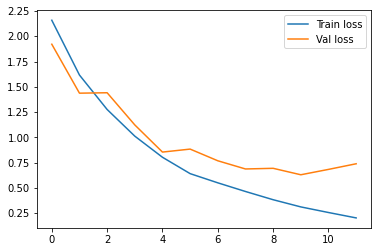

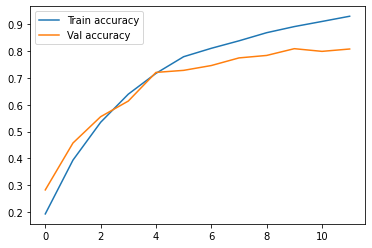

In [ ]:
val_size = 2500 
train_size = 50000 - val_size

batch_size = 128
lr = 0.01
momentum = 0.9
epochs = 12

transform = transforms.Compose([transforms.ToTensor()])
data_set = torchvision.datasets.CIFAR10(root='./cifar-10/', train=True, download=True, transform=transform)
train_set, val_set = random_split(data_set, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


n_train = len(train_set)
n_val = len(val_set)

epochs_loss_train = []
epochs_loss_val = []
epochs_acc_train = []
epochs_acc_val = []

max_val_acc = 0

for epoch in range(epochs):  

    # training
    model.train()
    train_loss = 0
    train_acc = 0
    total = 0
    iter = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader, 0):
        
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predictions = outputs.max(1)
        train_acc += float((predictions == labels).sum())

        iter += 1
        total += predictions.size(0)

        if batch_idx % 30 == 0:
            print(f"[{epoch+1} {batch_idx}] Train Loss: {train_loss/iter} Train Accuracy: {train_acc/total}")

    epochs_loss_train.append(train_loss/iter)
    epochs_acc_train.append(train_acc/total)
    

    
    # validation
    model.eval()
    val_loss = 0.0
    val_acc = 0
    iter = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(val_loader, 0):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predictions = outputs.max(1)
        val_acc += float((predictions == labels).sum())
        iter += 1
        total += predictions.size(0)
        if batch_idx % 3 == 0:
            print(f"[{epoch+1} {batch_idx}] Validation Loss: {val_loss/iter} Validation Accuracy: {val_acc/total}")

    epochs_loss_val.append(val_loss/iter)
    epochs_acc_val.append(val_acc/total)

torch.save(model.state_dict(), 'model_state_dict.pth')

# plotting the loss through the epochs
plt.plot(epochs_loss_train, label="Train loss")
plt.plot(epochs_loss_val, label="Val loss")
plt.legend()
plt.show()

# plotting the accuracy through the epochs
plt.plot(epochs_acc_train, label="Train accuracy")
plt.plot(epochs_acc_val, label="Val accuracy")
plt.legend()
plt.show()
    


### Defining the functions to execute the FGSM attack

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

'''
function which executes the fast gradient sign method attack to the input image
input parameters:
- model: the network to fool
- x: the input image
- eps: parameter between 0 and 1 to regulate the noise to add to the original image
- label: the true label of the input image
- loss: the loss function used to train the model
'''
def fast_gradient_sign(model : nn.Module, x : Tensor, eps, labels : Tensor, loss) -> Tensor:
    x.requires_grad = True
    model.zero_grad()

    # the output of the model for the input image
    out = model(x)

    # computing the loss of the output w.r.t. the true label of the image
    l = loss(out, labels)

    # call to the backward method of the loss to get the gradient of the loss function
    # w.r.t. the input image
    l.backward()

    # the sign of the gradient of the loss w.r.t the input will be used as the noise to
    # add to the image for the attack
    noise =  x.grad.sign()
    
    # adding to the input image the noise multiplied by the scaling factor epsilon
    x_att = x + eps*noise

    # making sure that each value of the attacked image is between 0 and 1
    x_att = torch.clamp(x_att, 0, 1)
    return x_att

def approx(x, digits):
    t = 10**digits
    return int(x*t)/t


'''
function to plot the result of the FGSM attack
input parameters:
- the original image 
- the image produced by the FGSM attack
- the noise generated by the FGSM
- a tuple which contains:
  - the ouput class of the model for the original image
  - the confidence of the model for that class
- a tuple which contains:
  - the ouput class of the model for the modified image
  - the confidence of the model for that class
- the epsilon parameter of the FGSM attack
'''
def plot_attack(original : Tensor, noise : Tensor, attaccked, org : tuple, att : tuple, eps : float):
    org_class, org_prob = org
    att_class, att_prob = att
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(original.permute(1,2,0))
    axs[1].imshow(noise.permute(1,2,0))
    axs[2].imshow(attaccked.permute(1,2,0))

    for i in range(3):
        axs[i].set_xticks([])
        axs[i].set_yticks([])

    org_title = r"$x$"
    noise_title = r'$sign(\nabla_x \ J(x;\theta))$'
    att_title = r'$x + \epsilon \cdot sign(\nabla_x \ J(x;\theta))$'
    axs[0].set_title(org_title, loc='center')
    axs[1].set_title(noise_title, loc='center')
    axs[2].set_title(att_title, loc='center')


    org_label = f"{org_class} with probability {approx(org_prob[0], 3)}%"
    noise_label = r"$\epsilon = $" + str(eps) 
    att_label = f"{att_class} with probability {approx(att_prob[0], 3)}%"
    axs[0].set_xlabel(org_label)
    axs[1].set_xlabel(noise_label)
    axs[2].set_xlabel(att_label)


    plt.show()

'''
function which executes the FSGM attack and plots the result of the attack:
input parameters:
- model: the network to fool
- x: the input image
- eps: parameter between 0 and 1 to regulate the noise to add to the original image
- label: the true label of the input image
- loss: the loss function used to train the model
'''
def fast_gradient_sign_plot(model : nn.Module, x : Tensor, eps, labels : Tensor, loss) -> None:
    x.requires_grad = True
    model.zero_grad()
    out_org = model(x)
    

    '''
    the softmax is used to get the probability distribution of the 10 classes for
    both the original image and the attacked image
    '''
    org_prob, org_idx  = softmax(out_org, 1).max(1)
    org_class = class_names[int(org_idx)]

    l = loss(out_org, labels)
    l.backward()
    noise =  x.grad.sign()
    x_att = x + eps*noise
    x_att = torch.clamp(x_att, 0, 1)
    

    out_att = model(x_att)
    att_prob, att_idx = softmax(out_att, 1).max(1)
    att_class = class_names[int(att_idx)]

    x_att = x_att.detach()
    x = x.detach()
    for idx in range(len(x)):
      plot_attack(x[idx], noise[idx], x_att[idx], (org_class, org_prob), (att_class, att_prob), eps)
    # return x_att

### Testing the accuracy on the network on original and attacked images of CIFAR-10 test set

After the training we test the accuracy of the model on the CIFAR-10 test set, which is composed by 10000 images. We also measure the accuracy of the model on the same set, but this time we apply the Fast Gradient Sign Method Attack to each image, in order to check how the attack affects the accuracy of the model.

The accuracy on the original images is 80%, while on the attacked images (with $\epsilon = 0.007$) the accuracy drops to 32%.

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
test_set = torchvision.datasets.CIFAR10(root='./cifar-10/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

model = Network(10)
if exists("model_state_dict.pth"):
    checkpoint = torch.load("model_state_dict.pth")
    model.load_state_dict(checkpoint)

acc_org = 0
acc_att = 0
total = 0
eps = 0.007

model.eval()
model.to(device)

for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    attacked = fast_gradient_sign(model, inputs, eps, labels, nn.CrossEntropyLoss())

    outputs_org = model(inputs)
    _, predictions_org = outputs_org.max(1)
    acc_org += (predictions_org == labels).sum()

    outputs_att = model(attacked)
    _, predictions_att = outputs_att.max(1)
    acc_att += (predictions_att == labels).sum()

    total += predictions_org.size(0)

print(f"Accuracy on original images {acc_org/total}")
print(f"Accuracy on attacked images {acc_att/total}")


Files already downloaded and verified
Accuracy on original images 0.8057999610900879
Accuracy on attacked images 0.32359999418258667


### Visualizing the attack
We show the effect of the attack on some images by plotting for each image:
* The original image and the prediction of the model for that image
* The noise generated by the FGSM attack
* The attacked image and the prediction of the model for that image

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


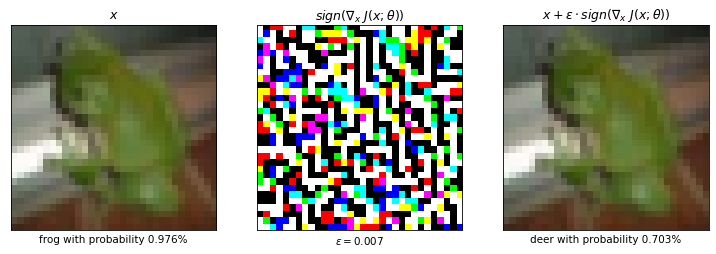

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


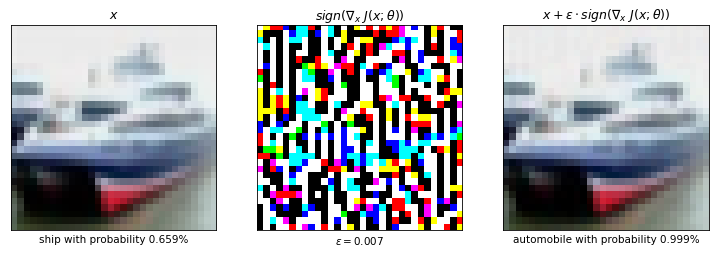

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


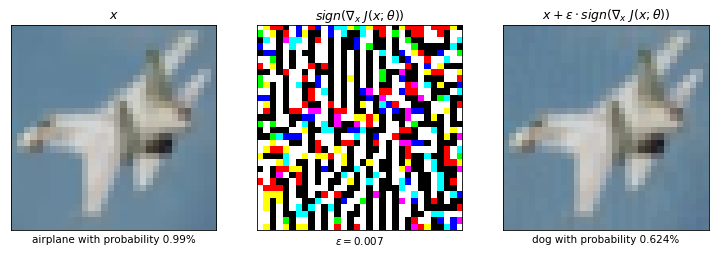

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


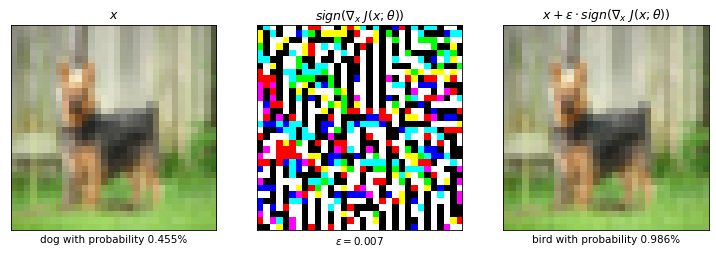

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


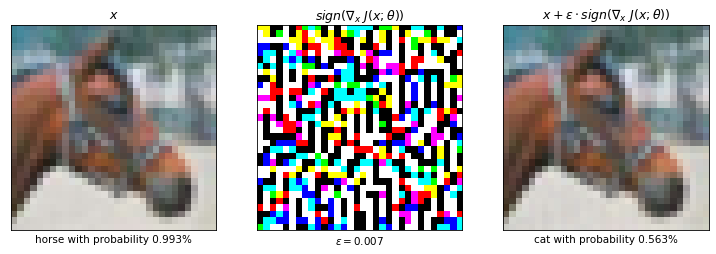

In [ ]:
# transform = transforms.Compose([transforms.ToTensor()])
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 75

test_set = torchvision.datasets.CIFAR10(root='./cifar-10/', train=False, download=True, transform=transform)

eps = 0.007

model = Network(10)
if exists("model_state_dict.pth"):
    checkpoint = torch.load("model_state_dict.pth")
    model.load_state_dict(checkpoint)

# image, label = test_set[8795]
# image = image.reshape(1, 3, 32, 32)
# label = torch.as_tensor([label])
# model.eval()
# fast_gradient_sign_plot(model, image, eps, label, nn.CrossEntropyLoss())


for idx in [7,1,10,24,17]:
    image, label = test_set[idx]
    image = image.reshape(1, 3, 32, 32)
    label = torch.as_tensor([label])
    model.eval()
    fast_gradient_sign_plot(model, image, eps, label, nn.CrossEntropyLoss())